Found 2612 images belonging to 2 classes.
Found 652 images belonging to 2 classes.
Epoch 1/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 155s 2s/step - accuracy: 0.8595 - loss: 1.0313 - val_accuracy: 0.8804 - val_loss: 1.1236 - learning_rate: 5.0000e-04
Epoch 2/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 151s 2s/step - accuracy: 0.8774 - loss: 0.9246 - val_accuracy: 0.8804 - val_loss: 1.0745 - learning_rate: 5.0000e-04
Epoch 3/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 134s 2s/step - accuracy: 0.8724 - loss: 0.8775 - val_accuracy: 0.8804 - val_loss: 0.9916 - learning_rate: 5.0000e-04
Epoch 4/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 152s 2s/step - accuracy: 0.8686 - loss: 0.8352 - val_accuracy: 0.8804 - val_loss: 0.9292 - learning_rate: 5.0000e-04
Epoch 5/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 135s 2s/step - accuracy: 0.8864 - loss: 0.7566 - val_accuracy: 0.8804 - val_loss: 0.8778 - learning_rate: 5.0000e-04
Epoch 6/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 149s 2s/step - accuracy: 0.8835 - loss: 0.7060 - val_accuracy: 0.8804 - val_loss: 0.7907 - learning_rate

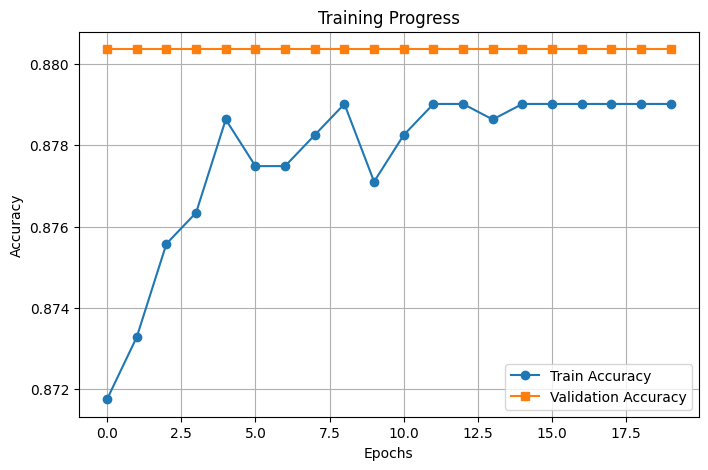

Model Saved Successfully!


In [8]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import AdamW
import matplotlib.pyplot as plt

# ------------------------- CONFIGURATION -------------------------
IMG_SIZE = (224, 224)  # Smaller for speed
BATCH_SIZE = 32  # Standard batch size
DATASET_PATH = "/kaggle/input/brain-tumor-classification-mri"
EPOCHS = 20  # Lower epochs for speed
LEARNING_RATE = 0.0005

# ---------------------- DATA AUGMENTATION ------------------------
data_generator = ImageDataGenerator(
    rescale=1.0 / 255.0,
    validation_split=0.2,
    rotation_range=30,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_data = data_generator.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_data = data_generator.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

# -------------------- MODEL CREATION (EfficientNetB0) -------------------
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freezing for faster training

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001))(x)
x = Dropout(0.4)(x)
x = Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001))(x)
x = Dropout(0.3)(x)
output_layer = Dense(train_data.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output_layer)

# ---------------------- COMPILATION ----------------------
model.compile(optimizer=AdamW(learning_rate=LEARNING_RATE, weight_decay=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# ---------------------- TRAINING ----------------------
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.4, patience=2, min_lr=1e-6)

history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=EPOCHS,
    callbacks=[early_stop, lr_scheduler]
)

# ---------------------- EVALUATION ----------------------
eval_loss, eval_acc = model.evaluate(val_data)
print(f"Final Validation Accuracy: {eval_acc * 100:.2f}%")

# ---------------------- RESULTS VISUALIZATION ----------------------
def plot_results(history):
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='s')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training Progress')
    plt.grid(True)
    plt.show()

plot_results(history)

# ---------------------- MODEL SAVING ----------------------
model.save("brain_tumor_model_optimized.h5")
print("Model Saved Successfully!")
